In [ ]:
!pip install pulp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.2 MB 7.4 MB/s 


In [ ]:
#jic we need these
import numpy as np
from scipy.optimize import minimize, LinearConstraint
import matplotlib.pyplot as plt

import pulp as pl

In [206]:
def run_optimization(solar, building_load, desired_ev_charge, battery_storage_amt, previous_peak_kw, start, end, plot_header,demand_risk_tolerance):
  
  T=end-start

  #TARIFFS
  tariffRates = [4.286,4.286,4.286,4.286,4.286,4.286,4.286,4.286,4.286,6,6,6,6,6,6,6,6,6,6,6,6,6,4.286,4.286]
  #multiply by 100 because this is dollars, not cents
  demandTariff=23.14*100

  #define solar production and base load curves throughout the day
  tod=np.arange(0,24).tolist()

  #slice tariffs, solar, and building_load by the start times and end times
  tariffRates_period=tariffRates[start:end]
  solar_period=solar[start:end]
  building_load_period=building_load[start:end]

  #predictions for upcoming building load & solar production
  solar_pred=solar[end:24]
  building_load_pred=building_load[end:24]
  demand_gap=previous_peak_kw-np.subtract(building_load_pred, solar_pred)

  #assess peak demand risk for upcoming hours
  peak_demand_risk=0
  for hour in range(24-end):
    if demand_gap[hour] <= battery_storage_amt/storage_charge_draw*demand_risk_tolerance:
      peak_demand_risk=1
      break

  #start optimization definitions
  def BooleanVariable(name):
    return pl.LpVariable(name, 0, 1, cat='Integer')

  charge_ev = [BooleanVariable(f"C{t}") for t in range(T)]
  use_storage = [BooleanVariable(f"S{t}") for t in range(T)]

  prob = pl.LpProblem("EV_with_Solar_Storage", pl.LpMinimize)

  electricityCost = pl.lpSum([tariffRates_period[t] * (ev_charge_draw * charge_ev[t] + building_load_period[t] - solar_period[t] - storage_charge_draw * use_storage[t]) for t in range(T)])

  #how much solar/building load can we expect in the next 24 hours and do we need to save battery storage for that?
  #demandRiskCost = [demandTariff * ( building_load_period[t] + ev_charge_draw * charge_ev[t] - solar_period[t] - storage_charge_draw * use_storage[t] - previous_peak_kw) for t in range(T)]
  demandRiskCost = [demandTariff*peak_demand_risk*storage_charge_draw * use_storage[t] for t in range(T)]

  # objective function
  prob += (
      electricityCost + demandRiskCost
  )

  # add constraint -- EV must be fully charged at the end
  prob += pl.lpSum([ev_charge_draw * charge_ev[t] for t in range(T)]) == desired_ev_charge

  # add constraint -- only charge as much as is in the storage battery
  prob += pl.lpSum([storage_charge_draw * use_storage[t] for t in range(T)]) <= battery_storage_amt

  # add constraint -- do not exceed max demand
  for t in range(T):
    prob += building_load_period[t] + ev_charge_draw * charge_ev[t] - solar_period[t] - storage_charge_draw * use_storage[t] <= previous_peak_kw

  # add constraint -- do not go negative in load (no buyback)
  for t in range(T):
    prob += (ev_charge_draw * charge_ev[t] + building_load_period[t] - solar_period[t] - storage_charge_draw * use_storage[t]) >= 0

  prob.solve()

  solution = {}

  print("Status:", pl.LpStatus[prob.status])

  c_opt=[]
  s_opt=[]
  for v in prob.variables():
    solution[v.name] = v.varValue

  if pl.LpStatus[prob.status]=='Optimal':
    # The optimised objective function value is printed to the screen
    # Each of the variables is printed with it's resolved optimum value
    for v in prob.variables():
      print(v.name, "=", v.varValue)

    print("Total Cost of Electricity = ","${:.2f}".format(pl.value(prob.objective)))

  #solutions for entire day
  ev_kw=[0]*start + [ev_charge_draw*solution[f"C{t}"] for t in range(T)] + [0]*(24-end)
  #storage_kw=[0]*start + [storage_charge_draw*solution[f"S{t}"] for t in range(T)] + [0]*(24-end)
  storage_kw=[0]*start + [storage_charge_draw*solution[f"S{t}"] for t in range(T)] + [storage_charge_draw if demand_gap[hour] <= battery_storage_amt/storage_charge_draw else 0 for hour in range(24-end)]
  consumed_kw=np.add(ev_kw, building_load)
  generated_kw=np.add([i * -1 for i in storage_kw], [i * -1 for i in solar])
  net_kw=np.add(consumed_kw,generated_kw)

  #plot everything
  plt.rcParams["figure.figsize"] = (15,12)
  plt.title(plot_header,fontsize=20)
  plt.axhline(y = previous_peak_kw, color = 'r', linestyle = '-',dashes=[2, 2],label="Previous Demand Peak")
  #plt.plot(building_load,label='Building kW')
  plt.plot(ev_kw, label="EV Charging kW", color="purple")
  #plt.plot(solar,label='Solar kW')
  plt.plot(storage_kw, label="Storage kW", color="green")
  plt.plot(net_kw, label="Net Load kW", color="red")
  plt.plot(tariffRates, label="Cost per kWh", color="black", linestyle='dashed')
  plt.axvspan(start, end, color="yellow", alpha=0.2, label="Smart Charging Period")
  plt.text(0, previous_peak_kw*0.95, "Cost = "+"${:.2f}".format(pl.value(prob.objective)),fontsize=16, bbox=dict(facecolor='green', alpha=0.5))
  plt.legend(fontsize=16,loc="upper right")

In [150]:
#Define default profiles
solar=[0,0,0,0,0,0,5,10,10,20,25,30,35,36,35,35,25,10,5,0,0,0,0,0]
building_load=[20,20,20,20,20,20,20,20,20,20,20,20,60,60,80,80,40,30,30,20,20,20,20,20]

#CONSTANTS
ev_charge_draw = 50
storage_charge_draw = 10

Status: Optimal
C0 = 1.0
C1 = 1.0
C2 = 0.0
C3 = 0.0
C4 = 0.0
C5 = 0.0
C6 = 0.0
C7 = 0.0
S0 = 0.0
S1 = 0.0
S2 = 0.0
S3 = 0.0
S4 = 0.0
S5 = 0.0
S6 = 1.0
S7 = 0.0
Total Cost of Electricity =  $878.63


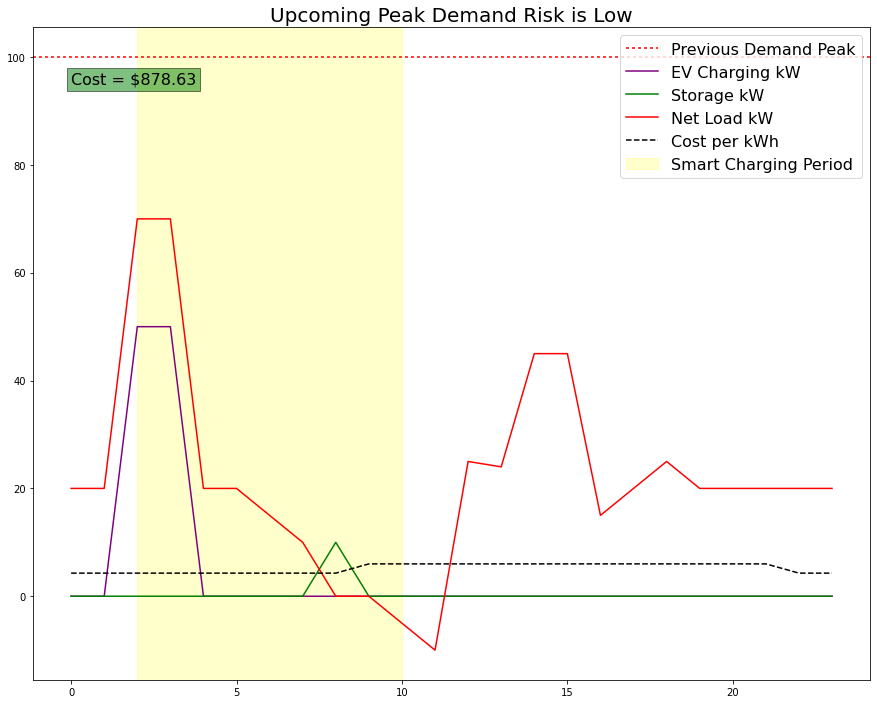

In [209]:
desired_ev_charge=100
battery_storage_amt=10
previous_peak_kw=100
start=2
end=10
demand_risk_tolerance=1

run_optimization(solar, building_load, desired_ev_charge, battery_storage_amt, previous_peak_kw, start, end, "Upcoming Peak Demand Risk is Low",demand_risk_tolerance)

Status: Optimal
C0 = 1.0
C1 = 1.0
C2 = 0.0
C3 = 0.0
C4 = 0.0
C5 = 0.0
C6 = 0.0
C7 = 0.0
S0 = 0.0
S1 = 0.0
S2 = 0.0
S3 = 0.0
S4 = 0.0
S5 = 0.0
S6 = 0.0
S7 = 0.0
Total Cost of Electricity =  $1148.64


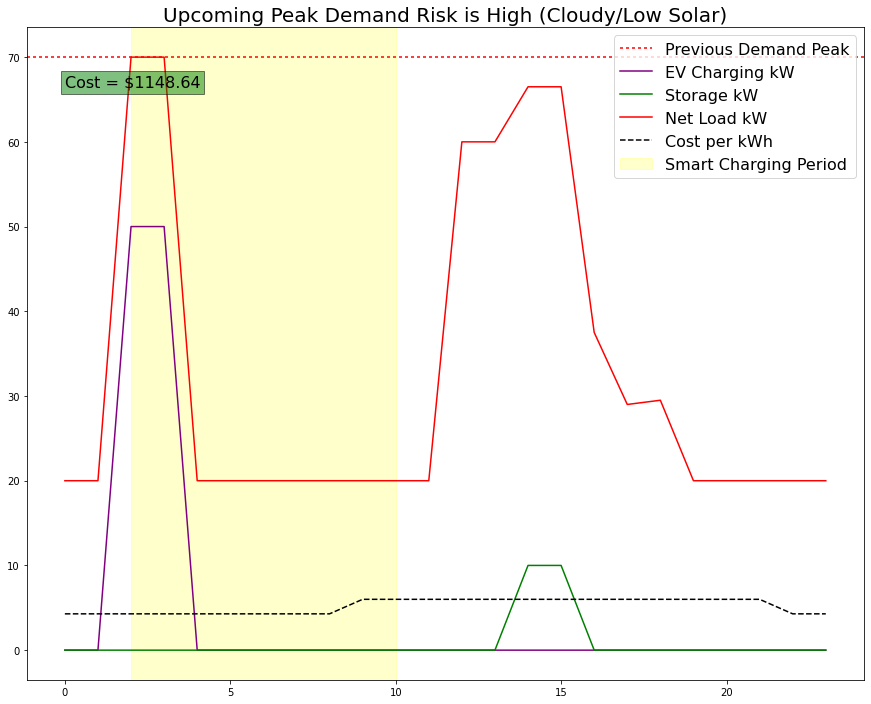

In [210]:
cloudy_solar = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.5,3.5,2.5,1,0.5,0,0,0,0,0]
desired_ev_charge=100
battery_storage_amt=10
previous_peak_kw=70
start=2
end=10
demand_risk_tolerance=1

run_optimization(cloudy_solar, building_load, desired_ev_charge, battery_storage_amt, previous_peak_kw, start, end, "Upcoming Peak Demand Risk is High (Cloudy/Low Solar)",demand_risk_tolerance)

Status: Infeasible


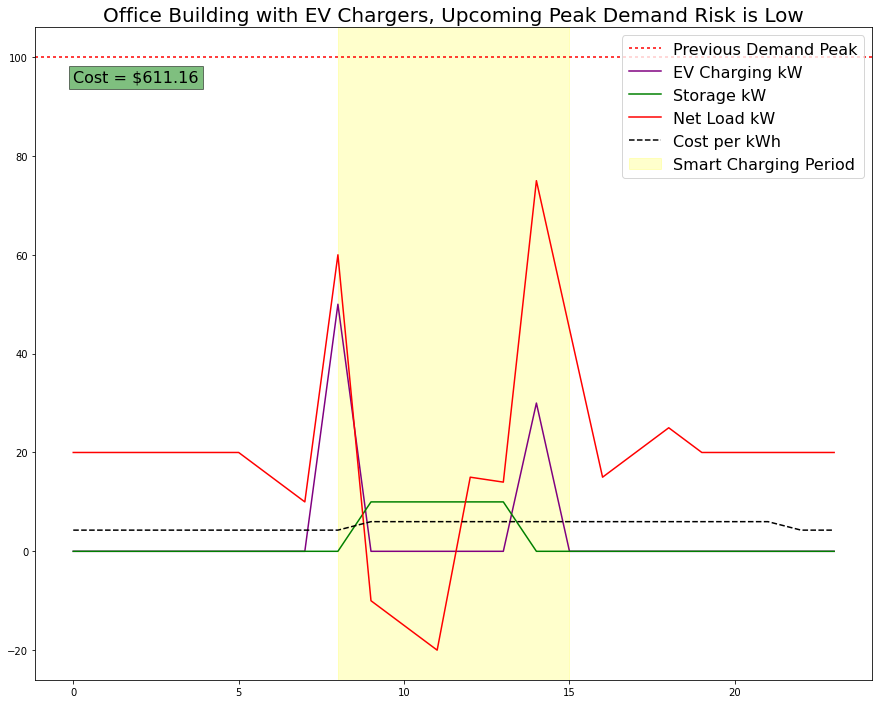

In [205]:
desired_ev_charge=80
battery_storage_amt=50
previous_peak_kw=100
start=8
end=15
demand_risk_tolerance=1
run_optimization(solar, building_load, desired_ev_charge, battery_storage_amt, previous_peak_kw, start, end, "Office Building with EV Chargers, Upcoming Peak Demand Risk is Low", demand_risk_tolerance)
#plot_optimization("Office Building with EV Chargers",building_load,solar)